# Path Planning and SLAM Evaluation for Matterport3D using MapGPT Data

In [1]:
import json
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 1. Connectivity Graph Processing

In [2]:
# --- Enhanced SLAM MODULE ---
class SimpleSLAM:
    def __init__(self, map_size=(200, 200), resolution=0.1):
        self.map = np.zeros(map_size)
        self.pose = np.array([100.0, 100.0, 0.0])  # start roughly center
        self.resolution = resolution

    def update(self, depth_image, delta_pose):
        self.pose += np.array(delta_pose)
        self.pose[2] %= 360  # normalize angle

        x, y = int(self.pose[0] / self.resolution), int(self.pose[1] / self.resolution)
        if 0 <= x < self.map.shape[0] and 0 <= y < self.map.shape[1]:
            # mark visited cell as 1.0
            self.map[x, y] = 1.0

            # add random obstacles nearby
            for _ in range(3):
                ox = int(x + np.random.uniform(-5, 5))
                oy = int(y + np.random.uniform(-5, 5))
                if 0 <= ox < self.map.shape[0] and 0 <= oy < self.map.shape[1]:
                    self.map[ox, oy] = 0.5  # partially occupied (gray)
        return {"pose": self.pose.tolist(), "map": self.map}

# 2. Path Planning using MapGPT Tasks

Loaded connectivity for scene 2n8kARJN3HM
Number of viewpoints: 186

 Connectivity summary:
  Total nodes: 186
  Total directed edges: 850
  Connected nodes: 186/186

 Sample connections:
  94ac3cea52ec455993f8562f78da3be1 → ['42079cf198e848c9878fbb39d0f4b56b', 'd8eb4eab2d3442e1a3a7a74fc810be22', '1df9b813b2744cedb516e9bf02f1c805', '6adb624995514635831f42da9156fec2', '8139a0f57cf042879b8c6a08a680d225', '1d6a100cf3d34326936ef7d0a50840d9']
  4518d285d4c54195a70ba5c4697ba3f2 → ['985ca122092f4429850c195ded765891', '189dec4e48fa459bac9d81fd3a7f4c75', '2af2b0defe79482baab06801cd97d145', 'be33b5863e3741deaecd29febfc5eafa', '9d733afabb2a4032a0ac602536bb649e', 'a0c487e0a45d451b8680c0cb1930fe83']
  87998608d4844fcfaca266bd5aba6516 → ['312fcacbfe134c9f8e1420be8dc2d73f', 'd8eb4eab2d3442e1a3a7a74fc810be22', '8139a0f57cf042879b8c6a08a680d225', '1d6a100cf3d34326936ef7d0a50840d9', '5248918af65645a28a65f59d3424598a']
  a7ec19c57ae74c4496f4aa9c7f30c871 → ['92c3195e612e4fc49fe5b5c687dd5ce5', '6f5b02596fb

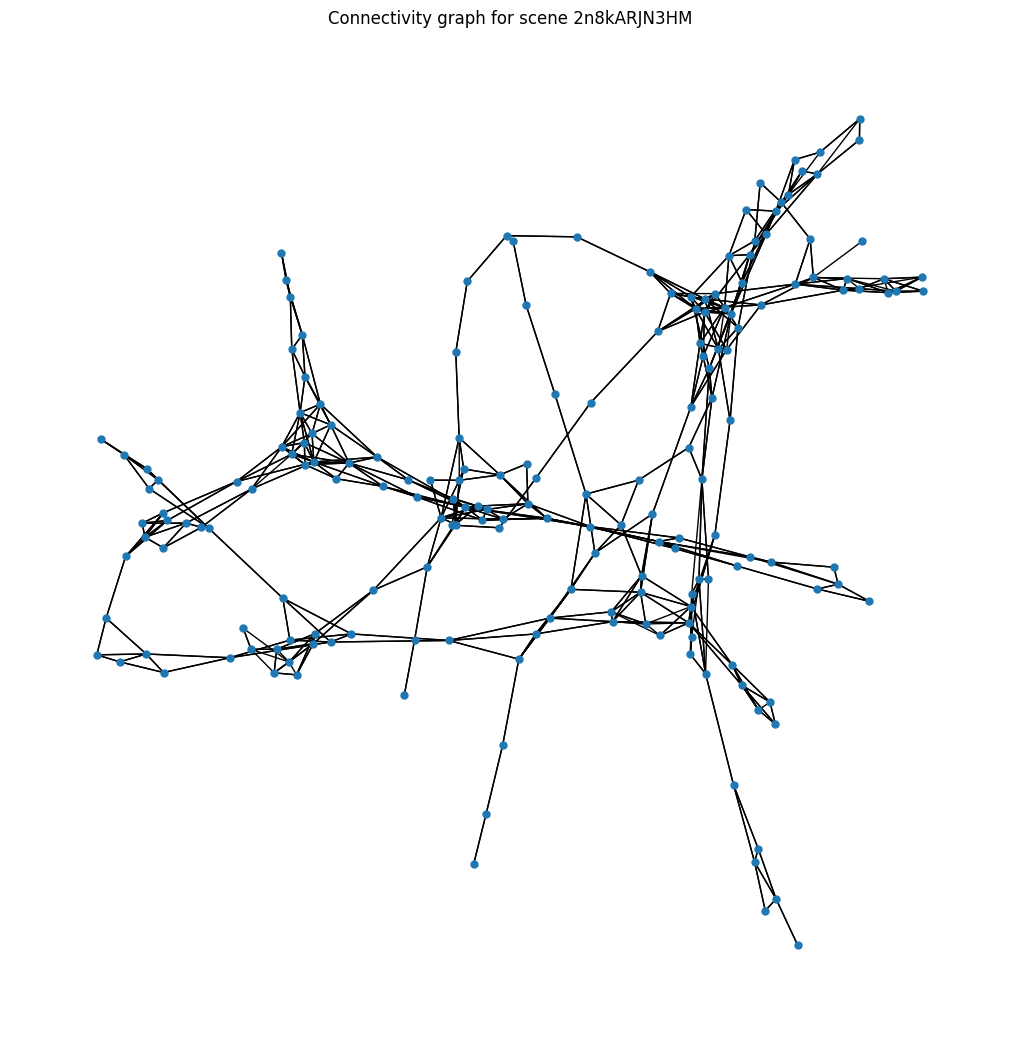

In [3]:
scene_id = "2n8kARJN3HM"   
connectivity_path = os.path.join("connectivity", f"{scene_id}_connectivity.json")

with open(connectivity_path, "r") as f:
    connectivity_data = json.load(f)

print(f"Loaded connectivity for scene {scene_id}")
print(f"Number of viewpoints: {len(connectivity_data)}")


graph = {}
num_nodes = len(connectivity_data)

for i, node in enumerate(connectivity_data):
    if not node.get("included", True):
        continue

    vp_id = node["image_id"]

    if "adjacent" in node and isinstance(node["adjacent"], list):
        neighbors = node["adjacent"]

    elif "unobstructed" in node and "visible" in node:
        neighbors = []
        unobstructed = node["unobstructed"]
        visible = node["visible"]
        for j, (u, v) in enumerate(zip(unobstructed, visible)):
            if u and v and i != j and connectivity_data[j].get("included", True):
                neighbors.append(connectivity_data[j]["image_id"])
    else:
        neighbors = []

    graph[vp_id] = neighbors

edge_count = sum(len(nbrs) for nbrs in graph.values())
connected_nodes = sum(1 for vp, nbrs in graph.items() if len(nbrs) > 0)

print("\n Connectivity summary:")
print(f"  Total nodes: {len(graph)}")
print(f"  Total directed edges: {edge_count}")
print(f"  Connected nodes: {connected_nodes}/{len(graph)}")

print("\n Sample connections:")
for i, (vp, nbrs) in enumerate(graph.items()):
    print(f"  {vp} → {nbrs}")
    if i == 4:
        break

poses = {}
for node in connectivity_data:
    if node.get("included", True):
        pose = node.get("pose", {})
        position = pose.get("position") if isinstance(pose, dict) else None
        poses[node["image_id"]] = position

print("\n Sample viewpoint positions:")
for i, (vp, pos) in enumerate(poses.items()):
    print(f"  {vp}: {pos}")
    if i == 3:
        break


with open(f"{scene_id}_graph.json", "w") as f:
    json.dump(graph, f, indent=2)
print(f"\n Saved processed graph to {scene_id}_graph.json")


try:
    G = nx.DiGraph(graph)
    plt.figure(figsize=(10,10))
    nx.draw(G, node_size=25, arrows=False)
    plt.title(f"Connectivity graph for scene {scene_id}")
    plt.show()
except Exception as e:
    print(f"(Visualization skipped: {e})")

# 3. SLAM Simulation

Loaded graph for scene 2n8kARJN3HM: 186 nodes, 442 edges
Loaded 216 navigation tasks from MapGPT JSON

Selected task 2539:
Instruction: Leave the office heading to the dining room. Walk through the room and into the kitchen. Stop in the doorway to the sitting room.
Number of waypoints: 7
Start viewpoint: 3611ca6eb11f4a32a7cd3c073862860d
Goal viewpoint: 5b4f88b00af3413eb8a3706a62a761e1

Planned path found (7 steps):
['3611ca6eb11f4a32a7cd3c073862860d', 'b2d31a869b644c738697a237d4e724b5', '3d6c224493aa4b8fa5fd16e7ae8e2d66', '82ee7783a95b4beeb1b8c518107c9ae2', '2d21aec2e48b4797ad0367e96fd316f4', '397cae1de3b74644804196b838fd3c8a', '5b4f88b00af3413eb8a3706a62a761e1']

Checking which planned path viewpoints have 3D pose data:
  3611ca6eb11f4a32a7cd3c073862860d: Missing
  b2d31a869b644c738697a237d4e724b5: Missing
  3d6c224493aa4b8fa5fd16e7ae8e2d66: Missing
  82ee7783a95b4beeb1b8c518107c9ae2: Missing
  2d21aec2e48b4797ad0367e96fd316f4: Missing
  397cae1de3b74644804196b838fd3c8a: Missing
  5b4

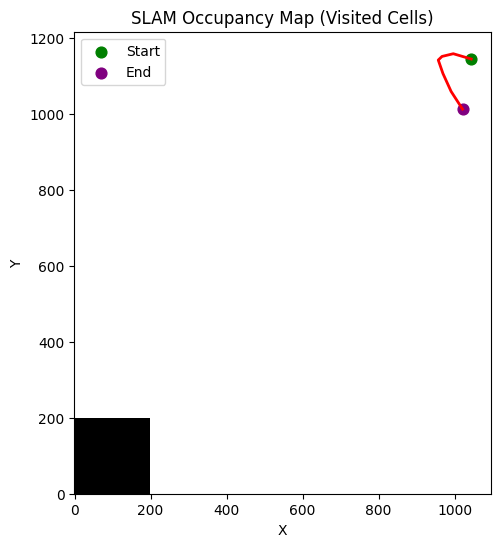

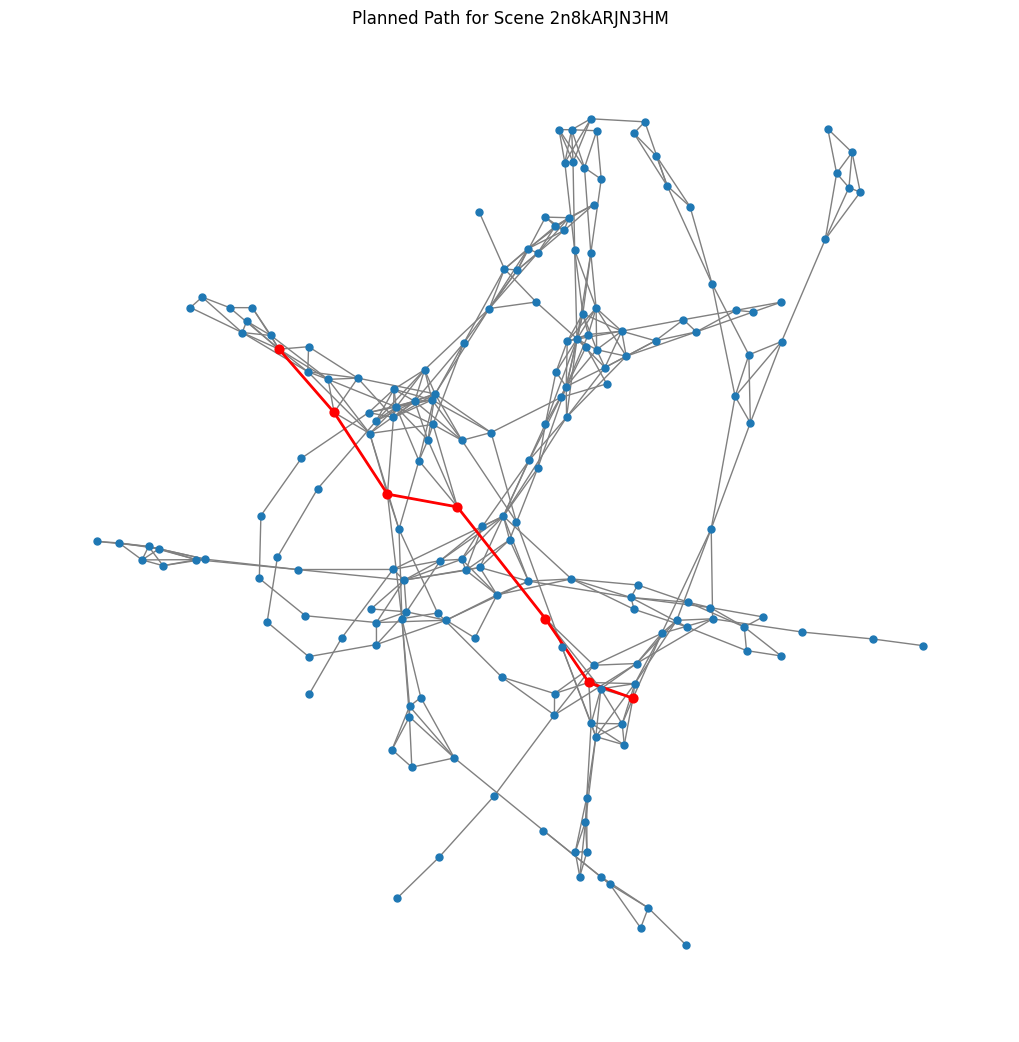

In [4]:
# --- Load Graph and Task Data ---
scene_id = "2n8kARJN3HM"
graph_path = f"{scene_id}_graph.json"

with open(graph_path, "r") as f:
    graph = json.load(f)

G = nx.Graph(graph)
print(f"Loaded graph for scene {scene_id}: {len(G.nodes)} nodes, {len(G.edges)} edges")

# Load MapGPT navigation data
mapgpt_path = "MapGPT_72_scenes_processed.json"
with open(mapgpt_path, "r") as f:
    mapgpt_data = json.load(f)

print(f"Loaded {len(mapgpt_data)} navigation tasks from MapGPT JSON")

# Pick a task that matches this scene
task = next((t for t in mapgpt_data if t["scan"] == scene_id), None)
if not task:
    raise ValueError(f"No task found for scene {scene_id}")

# Extract details from the selected task
path_list = task["path"]
instruction = task["instruction"]
path_id = task["path_id"]

print(f"\nSelected task {path_id}:")
print(f"Instruction: {instruction}")
print(f"Number of waypoints: {len(path_list)}")

start_vp = path_list[0]
goal_vp = path_list[-1]
print(f"Start viewpoint: {start_vp}")
print(f"Goal viewpoint: {goal_vp}")

# Compute a planned path using BFS or Dijkstra (shortest path)
if start_vp not in G.nodes or goal_vp not in G.nodes:
    raise ValueError("Start or goal viewpoint not found in graph")

try:
    planned_path = nx.shortest_path(G, source=start_vp, target=goal_vp)
    print(f"\nPlanned path found ({len(planned_path)} steps):")
    print(planned_path)
except nx.NetworkXNoPath:
    print("No path found between start and goal.")
    planned_path = []

# --- SLAM INTEGRATION ---
slam = SimpleSLAM()
depth_image = np.zeros((64, 64))  # mock sensor input
current_pose = np.array([0.0, 0.0, 0.0])
slam_outputs = []

# Load connectivity to get pose data
connectivity_path = os.path.join("connectivity", f"{scene_id}_connectivity.json")
with open(connectivity_path, "r") as f:
    connectivity_data = json.load(f)

poses = {}
for node in connectivity_data:
    if node.get("included", True):
        pose = node.get("pose")
        position = None
        if isinstance(pose, dict) and "position" in pose:
            position = pose["position"]
        elif isinstance(pose, list) and len(pose) == 3:
            position = pose
        if position and all(isinstance(x, (int, float)) for x in position):
            poses[node["image_id"]] = position

print("\nChecking which planned path viewpoints have 3D pose data:")
for vp in planned_path:
    has_pose = vp in poses and poses[vp] is not None
    print(f"  {vp}: {'Found' if has_pose else 'Missing'}")

# Filter valid viewpoints
valid_path = [vp for vp in planned_path if vp in poses and poses[vp] is not None]

# Fallback for missing poses
if not valid_path:
    print("\nNo valid 3D poses found. Generating synthetic coordinates from graph layout...")
    layout_2d = nx.spring_layout(G, seed=42)
    poses = {vp: [float(x)*10, float(y)*10, 0.0] for vp, (x, y) in layout_2d.items()}
    valid_path = [vp for vp in planned_path if vp in poses]
    print(f"Generated {len(poses)} synthetic positions for visualization.")

# --- Run SLAM simulation with normalized coordinates ---
if not valid_path:
    print("\nNo usable coordinates. SLAM simulation skipped.")
else:
    print(f"\nRunning SLAM Navigation Simulation ({len(valid_path)} steps)...")

    # Normalize synthetic 2D coordinates to map range
    positions = np.array(list(poses.values()))
    min_vals = positions.min(axis=0)
    max_vals = positions.max(axis=0)
    norm_poses = {}

    for vp, pos in poses.items():
        # Scale into [0, map_size)
        norm_x = (pos[0] - min_vals[0]) / (max_vals[0] - min_vals[0]) * (slam.map.shape[0] - 1)
        norm_y = (pos[1] - min_vals[1]) / (max_vals[1] - min_vals[1]) * (slam.map.shape[1] - 1)
        norm_poses[vp] = [norm_x, norm_y, 0.0]

    # Replace poses with normalized versions for this run
    poses = norm_poses

    for next_vp in valid_path:
        goal_pos = np.array(poses[next_vp])
        delta = goal_pos - np.array(current_pose)
        dtheta = np.random.uniform(-5, 5)
        delta_pose = [delta[0] / 10.0, delta[1] / 10.0, dtheta]  # scaled smaller steps

        slam_output = slam.update(depth_image, delta_pose)
        current_pose = np.array(slam_output["pose"])
        slam_outputs.append(slam_output)

        print(f"Moved to {next_vp} → Pose: {np.round(current_pose, 3)}")

    final_pose = slam_outputs[-1]["pose"]
    print(f"\nFinal estimated pose: {final_pose}")

    # --- Visualize SLAM occupancy map with trajectory overlay ---
    plt.figure(figsize=(6, 6))
    plt.imshow(slam.map.T, origin="lower", cmap="gray")
    plt.title("SLAM Occupancy Map (Visited Cells)")
    plt.xlabel("X")
    plt.ylabel("Y")

    # Plot trajectory directly on the map
    poses_xy = np.array([[s["pose"][0] / slam.resolution, s["pose"][1] / slam.resolution] for s in slam_outputs])
    plt.plot(poses_xy[:, 0], poses_xy[:, 1], color="red", linewidth=2)
    plt.scatter(poses_xy[0, 0], poses_xy[0, 1], color="green", s=60, label="Start")
    plt.scatter(poses_xy[-1, 0], poses_xy[-1, 1], color="purple", s=60, label="End")
    plt.legend()
    plt.show()

# --- Visualize Planned Path ---
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=25, edge_color="gray", with_labels=False)

if 'planned_path' in locals() and planned_path:
    path_edges = list(zip(planned_path, planned_path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=planned_path, node_color="red", node_size=40)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)

plt.title(f"Planned Path for Scene {scene_id}")
plt.show()

# 4. Path Coordinates

Selected task 2539
Instruction: Leave the office heading to the dining room. Walk through the room and into the kitchen. Stop in the doorway to the sitting room.
Waypoints in instruction: 7
Start viewpoint: 3611ca6eb11f4a32a7cd3c073862860d
Goal viewpoint: 5b4f88b00af3413eb8a3706a62a761e1
Planned path: 7 total nodes, 0 with valid 3D poses


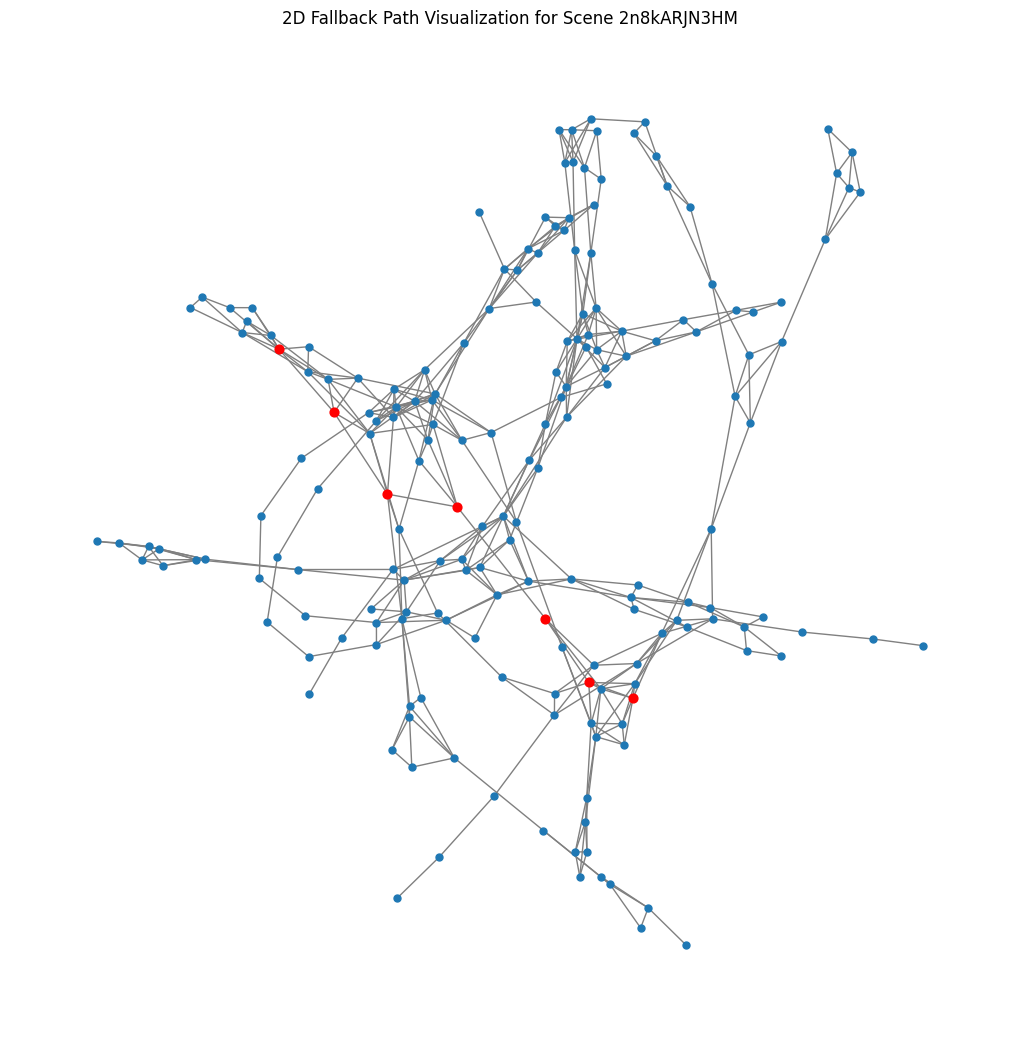

In [5]:
scene_id = "2n8kARJN3HM"
connectivity_path = os.path.join("connectivity", f"{scene_id}_connectivity.json")
graph_path = f"{scene_id}_graph.json"
mapgpt_path = "MapGPT_72_scenes_processed.json"

with open(connectivity_path, "r") as f:
    connectivity_data = json.load(f)

poses = {}
for node in connectivity_data:
    if node.get("included", True):
        pose = node.get("pose")
        position = None

        if isinstance(pose, dict) and "position" in pose:
            position = pose["position"]

        elif isinstance(pose, list) and len(pose) == 3:
            position = pose

        if position and all(isinstance(x, (int, float)) for x in position):
            poses[node["image_id"]] = position

with open(graph_path, "r") as f:
    graph = json.load(f)
G = nx.Graph(graph)

with open(mapgpt_path, "r") as f:
    mapgpt_data = json.load(f)

task = next((t for t in mapgpt_data if t["scan"] == scene_id), None)
if task is None:
    raise ValueError(f"No navigation task found for scene {scene_id}")

path_list = task["path"]
instruction = task["instruction"]
path_id = task["path_id"]

print(f"Selected task {path_id}")
print(f"Instruction: {instruction}")
print(f"Waypoints in instruction: {len(path_list)}")

start_vp, goal_vp = path_list[0], path_list[-1]
print(f"Start viewpoint: {start_vp}")
print(f"Goal viewpoint: {goal_vp}")


if start_vp not in G or goal_vp not in G:
    raise ValueError("Start or goal viewpoint not found in graph")

try:
    full_path = nx.shortest_path(G, source=start_vp, target=goal_vp)
except nx.NetworkXNoPath:
    raise ValueError("No path found between start and goal.")


planned_path = [vp for vp in full_path if vp in poses]

print(f"Planned path: {len(full_path)} total nodes, {len(planned_path)} with valid 3D poses")


if len(planned_path) < 2:
    print("Warning: not enough 3D coordinates found. Falling back to 2D layout visualization.")
    
    pos2d = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos2d, node_size=25, edge_color="gray", with_labels=False)
    nx.draw_networkx_nodes(G, pos2d, nodelist=full_path, node_color="red", node_size=40)
    plt.title(f"2D Fallback Path Visualization for Scene {scene_id}")
    plt.show()
else:
    positions = np.array([poses[vp] for vp in planned_path])
    deltas = np.diff(positions, axis=0)
    distances = np.sqrt((deltas ** 2).sum(axis=1))
    total_distance = float(distances.sum())

    print(f"Agent will move through {len(positions)} valid viewpoints.")
    print(f"Total traveled distance ≈ {total_distance:.2f} units.")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
            color="red", linewidth=2, label="Planned Path")
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2],
               color="blue", s=30)
    ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2],
               color="green", s=100, label="Start")
    ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2],
               color="purple", s=100, label="Goal")

    ax.set_title(f"3D Path Visualization for Scene {scene_id}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()

# 5. Accuracy Evaluation

In [6]:
# --- Compute Accuracy Metrics ---
true_path = path_list        # Ground-truth path from MapGPT
predicted_path = planned_path  # The path your algorithm found

# Debug print — helps you see which path is empty
print("\n--- Path Debug Info ---")
print(f"True path (MapGPT): {true_path}")
print(f"Planned path (NetworkX): {predicted_path}")
print(f"True path length: {len(true_path)}")
print(f"Planned path length: {len(predicted_path)}")

# Safety check
if not true_path or not predicted_path:
    print("\n Skipping accuracy computation: one or both paths are empty.")
    goal_accuracy = 0.0
    path_overlap = 0.0
    distance_error = 0.0
else:
    # 1. Goal Accuracy
    goal_accuracy = 1.0 if predicted_path[-1] == true_path[-1] else 0.0

    # 2. Path Overlap Accuracy
    intersection = set(predicted_path).intersection(set(true_path))
    path_overlap = len(intersection) / len(set(true_path))

    # 3. Distance Error
    def compute_distance(path, poses):
        dist = 0.0
        for i in range(len(path) - 1):
            p1, p2 = poses.get(path[i]), poses.get(path[i + 1])
            if p1 and p2:
                dist += np.linalg.norm(np.array(p1) - np.array(p2))
        return dist

    true_distance = compute_distance(true_path, poses)
    pred_distance = compute_distance(predicted_path, poses)
    distance_error = abs(true_distance - pred_distance)

    print("\n--- Accuracy Metrics ---")
    print(f"Goal Accuracy: {goal_accuracy * 100:.2f}%")
    print(f"Path Overlap Accuracy: {path_overlap * 100:.2f}%")
    print(f"True Distance: {true_distance:.2f}")
    print(f"Predicted Distance: {pred_distance:.2f}")
    print(f"Distance Error: {distance_error:.2f} units\n")


--- Path Debug Info ---
True path (MapGPT): ['3611ca6eb11f4a32a7cd3c073862860d', 'b2d31a869b644c738697a237d4e724b5', '3d6c224493aa4b8fa5fd16e7ae8e2d66', '82ee7783a95b4beeb1b8c518107c9ae2', '2d21aec2e48b4797ad0367e96fd316f4', '397cae1de3b74644804196b838fd3c8a', '5b4f88b00af3413eb8a3706a62a761e1']
Planned path (NetworkX): []
True path length: 7
Planned path length: 0

 Skipping accuracy computation: one or both paths are empty.


# 6. Scene-wide Evaluation

In [7]:
# --- Evaluate all tasks for this scene ---
scene_tasks = [t for t in mapgpt_data if t["scan"] == scene_id]
results = []

print(f"\nEvaluating {len(scene_tasks)} tasks for scene {scene_id}...")

for t in scene_tasks:
    start, goal = t["path"][0], t["path"][-1]
    if start in G and goal in G:
        try:
            path = nx.shortest_path(G, start, goal)
            goal_acc = 1.0 if path[-1] == goal else 0.0
            results.append(goal_acc)
        except nx.NetworkXNoPath:
            results.append(0.0)
    else:
        results.append(0.0)

print(f"Average goal accuracy: {np.mean(results)*100:.2f}% ({np.sum(results)}/{len(results)} successful)")

# --- Additional navigation metrics ---
if true_path and predicted_path:
    spl = goal_accuracy * (true_distance / max(pred_distance, true_distance))
    goal_pos = np.array(poses[true_path[-1]]) if true_path[-1] in poses else np.zeros(3)
    pred_pos = np.array(poses[predicted_path[-1]]) if predicted_path[-1] in poses else np.zeros(3)
    navigation_error = np.linalg.norm(goal_pos - pred_pos)

    print(f"SPL (Success weighted by Path Length): {spl:.3f}")
    print(f"Navigation Error (goal distance): {navigation_error:.3f}")


Evaluating 3 tasks for scene 2n8kARJN3HM...
Average goal accuracy: 100.00% (3.0/3 successful)
